# Analysis of Weather in Athens for the period 1955 - 2020
* This is a project created in the context of the course: "Applied Machine Learning".
* Data are obtained from:
    1. The National Oceanic and Atmospheric Administration's National Centers for Environmental Information (https://www.ncdc.noaa.gov/cdo-web/)
    2. The Helenic Data Service (https://hellenicdataservice.gr/main/)
* The analysis will be done on [Jupyter](http://jupyter.org/).
---
> Georgios Sideris <br />
> geosideris@aueb.gr

## Import packages
* To begin with, we will import the packages that we will use in the following segments of the project:
    * [NumPy](https://www.numpy.org/)
    * [pandas](https://pandas.pydata.org/)
    * [matplotlib](https://matplotlib.org/)
    * [SciPy](https://www.scipy.org/)
* Note that the prementioned packages **must be locally installed too** in order to be used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats.stats as stats

%matplotlib inline

## Obtain the Data
* The data used for the analysis can be found in the folder <code>data</code>:
    * <code>data/hellinikon_noaa.csv</code>: contains the data downloaded from [NOAA](https://www.ncdc.noaa.gov/cdo-web/).
    * <code>data/athens_hds.csv</code>: contains the data downloaded from [HDS](https://hellenicdataservice.gr/main/).
* We will talk more about them in the following parts.


### Data from NOAA
* The data downloaded from the National Oceanic and Atmospheric Administration's National Centers for Environmental Information refer to the weather station of **Hellinikon** and the period **1955 - 2020**.
* To get them, the search feature of the NOAA website was used (https://www.ncdc.noaa.gov/cdo-web/search).
* Specifically, the filters used were:
    1. Dataset: *Daily Summaries*
    2. Date range: *1955-01-01 to 2020-12-31*
    3. Search for: *Stations*
    4. Search Term: *Hellinikon*  
* The station selected for the download is: *HELLINIKON, GR*
* The output format chosen is: *Custom GHCN-Daily CSV*
* Units were set to: *Metric* (in order to get the data in Celsius and millimeters instead of Fahrenheit and inches)
* Lastly the data types for custom output chosen were:
    1. Precipitation (PRCP) 
    2. Average Temperature (TAVG)
    3. Maximum temperature (TMAX)
    4. Minimum temperature (TMIN)
* The downloaded file was renamed to <code>hellinikon_noaa.csv</code> and can be found at the <code>data</code> folder.

#### Dataframe from NOAA
* Next we will generate a dataframe using the <code>data/hellinikon_noaa.csv</code> file.

In [2]:
data_hellinikon_noaa = "data/hellinikon_noaa.csv"
noaa_data = pd.read_csv(data_hellinikon_noaa,
                        parse_dates=["date"], 
                        usecols=range(2, 7), 
                        header=0, 
                        names=["date", "prcp", "avg_temp", "max_temp", "min_temp"])
noaa_data.head(5)

date  prcp  avg_temp  max_temp  min_temp
0 1955-01-01   0.0       NaN      18.5      10.2
1 1955-01-02   2.0       NaN      14.4       7.0
2 1955-01-03   0.0       NaN      15.8       9.6
3 1955-01-04   0.0       NaN      18.8       7.3
4 1955-01-05   0.0       NaN      17.9       8.4

### Data from HDS
* The data from the Helenic Data Service refer to the weather station of **Athens** and the period **2010-2019**.
* The relative file (**athens.csv**) can be found online [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f).
* The downloaded file was renamed to <code>athens_hds.csv</code> and can be found at the <code>data</code> folder.

#### Dataframe from HDS
* Next we will generate a dataframe using the <code>data/athens_hds.csv</code> file.
* The particular file contains information that we are not interested in (documentation can be found [here](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748)), so we will choose only the columns that refer to the *date*, the *average temperature* and the *precipitation* of each day.

In [3]:
data_athens_hds = "data/athens_hds.csv"
hds_data = pd.read_csv(data_athens_hds,
                       usecols=[0, 1, 10],
                       parse_dates=["date"],
                       names=["date", "avg_temp", "prcp"])
hds_data.head(5)

date avg_temp  prcp
0 2010-01-01     17.9   0.2
1 2010-01-02     15.6   0.0
2 2010-01-03     13.5   0.0
3 2010-01-04      9.5   0.0
4 2010-01-05     13.4   0.0

## Explore completeness of data
* Before using the generated dataframes we have to clean, explore and complete them.

### Clean
* A first issue, is the fact that the data from HDS contain dashes ("---"), for missing values, instead of empty cells.

In [4]:
hds_data.dtypes

date        datetime64[ns]
avg_temp            object
prcp               float64
dtype: object

* We can see that the <code>avg_temp</code> column was identified as of object type, instead of float64 (like <code>prcp</code>).
* So, we will replace the dashes with <code>nan</code> values and turn the avg_temp column to float.

In [5]:
hds_data["avg_temp"] = hds_data["avg_temp"] \
                       .map(lambda x : float("nan") if x == "---" else float(x))
hds_data.dtypes

date        datetime64[ns]
avg_temp           float64
prcp               float64
dtype: object

* Now the types of the columns look good.

In [6]:
noaa_data.dtypes

date        datetime64[ns]
prcp               float64
avg_temp           float64
max_temp           float64
min_temp           float64
dtype: object

* The types of the NOAA dataframe are also good.

* Another potential problem could be the existence of duplicate dates.
* Let's check it!

In [7]:
noaa_dates = noaa_data["date"]
hds_dates = hds_data["date"]
noaa_dates.duplicated().sum(), hds_dates.duplicated().sum()

(0, 0)

* That's great! We don't have duplicate dates.
* Now our data look clean, but are they complete?

### Explore
* Next we will check if there are **missing dates** or **missing values** from the existing dates.
* The <code>noaa_data</code> dataframe will be used as basis, while <code>hds_data</code> will be used as complement.

#### Missing dates

In [8]:
all_dates = pd.date_range(start='1955-01-01', end='2020/12/31') # a DateTimeIndex of all the days between 1/1/1955 and 31/12/20
len(all_dates)-len(noaa_dates)

856

* It seems like 856 days from the noaa_data_set are missing.
* Let's explore more.

In [9]:
noaa_missing_dates = all_dates[~all_dates.isin(noaa_dates)]
noaa_missing_dates_df = pd.DataFrame(noaa_missing_dates, columns=["date"])
noaa_missing_dates_df.groupby(noaa_missing_dates_df["date"].dt.year).size()

date
2006      2
2007      1
2012    206
2013    355
2014    267
2016      1
2017     23
2018      1
dtype: int64

* Looks like almost all the missing dates are from the period 2012-2018.
* <code>hds_data</code> dataframe comes in handy, as we can use it to fill the missing days.
* But, are there any missing dates from <code>hds_data</code>? 

In [10]:
dates_2010_2019 = pd.date_range(start='2010-01-01', end='2019/12/31') # a DateTimeIndex of all the days between 1/1/2010 and 31/12/2019
len(dates_2010_2019)-len(hds_dates)

0

* There isn't a day missing from <code>hds_data</code>, so we can complete our data using it.

#### Missing values
* It is necessary to also get an idea of the values that are missing from the dates that already exist in <code>noaa_data</code>.

In [11]:
noaa_data["prcp"].isnull().sum(), noaa_data["avg_temp"].isnull().sum()

(478, 2311)

* It looks like there are missing values.
* Let's have an indication of how many of them can be completed using <code>hds_data</code>.
* For that purpose we will calculate the missing values from the period 2010-2019 (of course from the existing dates in <code>noaa_data</code>).

In [12]:
(noaa_data["date"].dt.year.isin(range(2010, 2020)) & noaa_data["prcp"].isnull()).sum(), \
(noaa_data["date"].dt.year.isin(range(2010, 2020)) & noaa_data["avg_temp"].isnull()).sum()

(102, 0)

* Most of the missing values cannot be filled from <code>hds_data</code>.
* Especially, there are a lot of empty cells of *average temperature* (<code>avg_temp</code>).
* An interesting idea is to use the average of the max and min temperature, as the average temperature of the day.
* In order to apply that, we have to answer 2 questions:
    1. How many fields of average temperature can be filled in this way?
    2. And more importantly, how good estimation of the average temperature, the average(<code>min_temp</code>, <code>max_temp</code>) is?

* The first question can be easily answered.

In [13]:
calculatable_avg_temp = ( \
 ~ (noaa_data["max_temp"].isnull()) & \
 ~ (noaa_data["min_temp"].isnull()) & \
 (noaa_data["avg_temp"].isnull()) \
                        )

calculatable_avg_temp.sum() # the number of days with missing avg_temp but with available  max and min temp

2310

* The average temperature for almost every date can be filled if we choose to proceed with the application of this idea!
* But, we have to answer the second prementioned question.
* To do this, we will execute a very simple statistical analysis. 

In [14]:
# rows of the noaa dataset with no temperature field missing (avg_temp, max_temp, min_temp all not null)
noaa_data_full_temp = noaa_data[~ noaa_data.avg_temp.isnull() & \
                                ~ noaa_data.max_temp.isnull() & \
                                ~ noaa_data.min_temp.isnull()].copy()
print("obserbations:", len(noaa_data_full_temp))
noaa_data_full_temp["avg_min_max_temp"] = round((noaa_data_full_temp["min_temp"] + noaa_data_full_temp["max_temp"])/2, 1)

diff_of_avgs = noaa_data_full_temp["avg_temp"] - noaa_data_full_temp["avg_min_max_temp"]
corr = stats.pearsonr(noaa_data_full_temp["avg_min_max_temp"], noaa_data_full_temp["avg_temp"])[0]
diff_mean = diff_of_avgs.mean()
diff_std = diff_of_avgs.std()
print("correlation: {} \nmean of difference: {} \nstandard deviation of difference: {}".format(corr, diff_mean, diff_std))

obserbations: 19372
correlation: 0.9945909224510429 
mean of difference: -0.12309518893247984 
standard deviation of difference: 0.7169931309904884


* In the previous snipet of code, firstly, we created a view of the days that all min, max and average temperatures are available.
* Then, we calculated the difference: <code>avg_temp</code> - average(<code>max_temp</code>, <code>min_temp</code>).
* After, we found the Pearson correlation coefficient of the average(<code>max_temp</code>, <code>min_temp</code>), with the <code>avg_temp</code> and the mean and standard deviaton of this difference.
* What conclusion can we make?
    * The correlation coeffecient found is very high, over than 0.99
    * The mean found is only -0.12, with a standard deviation of less that a Celsius degree.
    * Also, the number of observations that we used is relatively large (19372).
    * As a result, we conclude that the average of the max and min temperature provide a very good estimation of the average temperature of a day, in the context of the particular analysis.

### Complete
* After our exploration of the data, we identified that in order to complete our data we have to:
    1. Fill the missing dates of <code>noaa_data</code>, from <code>hds_data</code>.
    2. Fill the missing precipitations from the existing dates of <code>noaa_data</code>, from <code>hds_data</code>.
    3. Fill the missing average temperatures of <code>noaa_data</code> using the average of max and min temperature.

* Initially, let's join <code>noaa_data</code> and <code>hds_data</code>.  

**It is crucial to mention a hypothesis that we do for this analysis: we assume that the data of the two sources refer to the same location.** Even though, we know that they are gotten from different weather stations, they are close enough, that it is rational to assume that the differences are insignificant.

In [15]:
full_data = pd.merge(noaa_data, hds_data, how ="outer", on ="date", suffixes=('_noaa', '_hds')) # outer is used in order to 
                                                                                                  # also get the missing dates
full_data = full_data.sort_values(by=["date"]) # after adding the new data our data are not in chronological order
full_data = full_data.reset_index(drop=True) # reset the index after reordering the rows
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

date  prcp_noaa  avg_temp_noaa  max_temp  min_temp  avg_temp_hds  \
20086 2010-01-01        NaN           18.0      21.8       NaN          17.9   
20087 2010-01-02        0.0           16.0      17.8      13.8          15.6   
20088 2010-01-03        0.0           13.5      15.6      10.8          13.5   
20089 2010-01-04        0.0            8.9      11.0       5.8           9.5   
20090 2010-01-05        0.0           13.1      16.0       8.6          13.4   

       prcp_hds  
20086       0.2  
20087       0.0  
20088       0.0  
20089       0.0  
20090       0.0

* Next, we will create a new column for precipitation, that we will contain:
    * <code>prcp_noaa</code> if it is not <code>NaN</code>.
    * <code>prcp_hds</code> if it is not <code>NaN</code> and <code>prcp_noaa</code> is <code>NaN</code>.
    * <code>NaN</code> in different case.

In [16]:
full_data["prcp"] = full_data["prcp_noaa"].fillna(full_data["prcp_hds"])
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

date  prcp_noaa  avg_temp_noaa  max_temp  min_temp  avg_temp_hds  \
20086 2010-01-01        NaN           18.0      21.8       NaN          17.9   
20087 2010-01-02        0.0           16.0      17.8      13.8          15.6   
20088 2010-01-03        0.0           13.5      15.6      10.8          13.5   
20089 2010-01-04        0.0            8.9      11.0       5.8           9.5   
20090 2010-01-05        0.0           13.1      16.0       8.6          13.4   

       prcp_hds  prcp  
20086       0.2   0.2  
20087       0.0   0.0  
20088       0.0   0.0  
20089       0.0   0.0  
20090       0.0   0.0

* We will follow the corresponding procedure for the average temperature.
* In the new column we will collect the average temperatures from <code>noaa_data</code>, but also the average temperatures from <code>hds_data</code> for the dates that were missing from <code>noaa_data</code>.

In [17]:
full_data["avg_temp"] = full_data["avg_temp_noaa"].fillna(full_data["avg_temp_hds"])
full_data[full_data["date"].dt.year.isin(range(2010, 2020))].head(5)

date  prcp_noaa  avg_temp_noaa  max_temp  min_temp  avg_temp_hds  \
20086 2010-01-01        NaN           18.0      21.8       NaN          17.9   
20087 2010-01-02        0.0           16.0      17.8      13.8          15.6   
20088 2010-01-03        0.0           13.5      15.6      10.8          13.5   
20089 2010-01-04        0.0            8.9      11.0       5.8           9.5   
20090 2010-01-05        0.0           13.1      16.0       8.6          13.4   

       prcp_hds  prcp  avg_temp  
20086       0.2   0.2      18.0  
20087       0.0   0.0      16.0  
20088       0.0   0.0      13.5  
20089       0.0   0.0       8.9  
20090       0.0   0.0      13.1

* Then we will add in the newly created <code>avg_temp</code> column the average(<code>max_temp</code>, <code>min_temp</code>) for the missing <code>avg_temp</code> values.
* *Note: in  case we don't want to use the average of min and max temperature as the average temperature of the day, the below cell should be commented out.*

In [18]:
# we have to recalculate calculateble_avg_temp after the merge
calculatable_avg_temp = ( \
 ~ (full_data["max_temp"].isnull()) & \
 ~ (full_data["min_temp"].isnull()) & \
 (full_data["avg_temp_noaa"].isnull()) \
                        )
                         
full_data["avg_temp"] = full_data["avg_temp"].where(~ calculatable_avg_temp, (full_data["max_temp"] + full_data["min_temp"]) /2)

* We will create a copy of <code>full_data</code> dataframe that will contain only the columns that are useful for our analysis.
* This will be the dataframe that we will work on.

In [19]:
df = full_data[["date", "prcp", "avg_temp"]].copy()
df.head(5)

date  prcp  avg_temp
0 1955-01-01   0.0     14.35
1 1955-01-02   2.0     10.70
2 1955-01-03   0.0     12.70
3 1955-01-04   0.0     13.05
4 1955-01-05   0.0     13.15

### Overview of data
* Let's calculate again some characteristics of our data after completing them.

In [20]:
print("missing dates:", len(all_dates) - len(df))
print("missing average temperatures:", df["avg_temp"].isnull().sum())
print("missing precipitations:", df["prcp"].isnull().sum())

missing dates: 3
missing average temperatures: 2
missing precipitations: 376


#### Looks like our data are much more complete now and we can move on with our analysis!

## Deviation of Summer Temperatures
* Beginning our analysis we will calculate the mean summer temperature deviation from a baseline of 1974-1999 and we will create the corresponding graph.
* An identical graph can be found in page 7 of the [report on extreme events](http://www.hnms.gr/emy/en/pdf/2020_GRsignificantEVENT_en.pdf) of the Hellenic National Meteorological Service.

* A column with the year of each row will be useful afterwards.

In [21]:
df["year"] = df["date"].dt.year

* Then, we will generate a view of the dataframe that contains only the summer days (by summer day we mean every day of June, July and August).

In [22]:
summerdays = df[df["date"].dt.month.isin(range(6, 9))]
summerdays.head(5)

date  prcp  avg_temp  year
151 1955-06-01   0.0      21.8  1955
152 1955-06-02   0.0      21.7  1955
153 1955-06-03   0.0      21.5  1955
154 1955-06-04   0.0      22.7  1955
155 1955-06-05   0.0      22.5  1955

* Now the mean temperature of the summer days within the base period 1974-1999, can be easily calculated.
* This is the baseline temperature that we will use to calculate the deviation.

In [23]:
base_summer_temp = summerdays.loc[summerdays["year"].isin(range(1974, 2000)), "avg_temp"].mean() # summerdays from 1974-1999
base_summer_temp

26.230727424749166

* In order to calculate the average temperature separately for each summer, we will group the summer days of every year.

In [24]:
summers_grouped = summerdays.groupby("year")
for name, summer_group in list(summers_grouped)[:3]:
    print(name)
    print(summer_group[:3])

1955
          date  prcp  avg_temp  year
151 1955-06-01   0.0      21.8  1955
152 1955-06-02   0.0      21.7  1955
153 1955-06-03   0.0      21.5  1955
1956
          date  prcp  avg_temp  year
517 1956-06-01   0.0     20.85  1956
518 1956-06-02   0.0     23.00  1956
519 1956-06-03   0.0     21.70  1956
1957
          date  prcp  avg_temp  year
882 1957-06-01   0.0      21.2  1957
883 1957-06-02   0.0      24.6  1957
884 1957-06-03   0.0      24.8  1957


* Now we need to calculate the average temperature of each summer.

In [25]:
summers_temp = summers_grouped["avg_temp"].mean()
summers_temp.head(5)

year
1955    25.951087
1956    27.143478
1957    27.371739
1958    27.081522
1959    26.401087
Name: avg_temp, dtype: float64

* Having calculated the average temperature of all the summers and also the baseline summer temperature, we can now calculate the deviation from the baseline for each summer.

In [26]:
summers_dev_from_base = summers_temp - base_summer_temp
summers_dev_from_base.head(5)

year
1955   -0.279640
1956    0.912751
1957    1.141012
1958    0.850794
1959    0.170360
Name: avg_temp, dtype: float64

* Additionally, it would be nice if we added to our graph a line, representing the 10 years rolling avarege of the deviation from the mean.
* In this way we will get a better picture of extreme events.

In [27]:
summers_roll_avg_dev = summers_dev_from_base.rolling(10, min_periods=1).mean()

### Plot
* Now it is time to plot our graph!
* We will use orange for the years with mean summer temperature over the baseline and blue for the years with mean summer temperature below it.

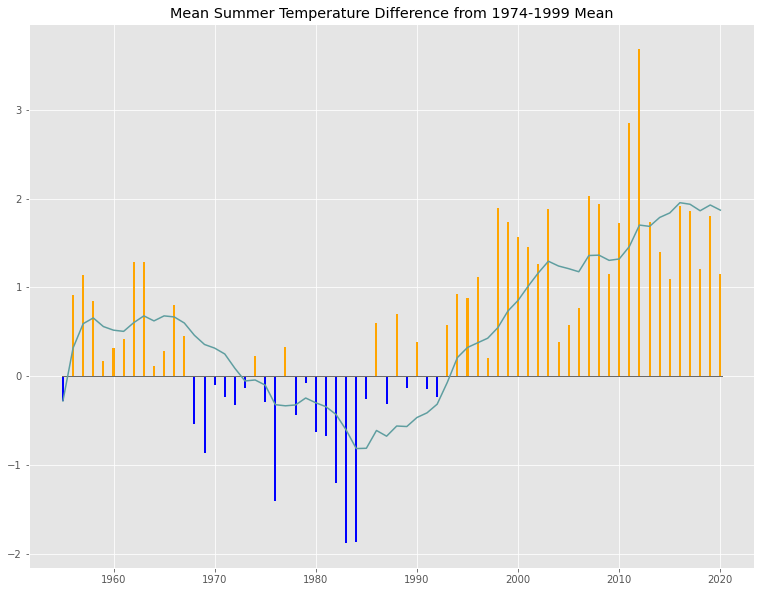

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(13, 10))
plt.title("Mean Summer Temperature Difference from 1974-1999 Mean")
plt.bar(summers_dev_from_base.index, 
        summers_dev_from_base, 
        width=0.2, 
        color=np.where(summers_dev_from_base < 0, 'blue', 'orange'),
        )
plt.axhline(xmin=0.045, xmax=0.955, color="dimgrey", linewidth=1) # for the line on the x axis
plt.plot(summers_roll_avg_dev.index, summers_roll_avg_dev, color="cadetblue")

### Interpretation
* The mean summer temperature fluctuated at relatively low levels in the period 1955-1995, and especially within 1964-1993.
* In the period 1996-2020 the mean summer temperature is almost every year a degree higher than the baseline temperature.
* Generally, the trend is upwards.
* A  relative steadiness can be noted in the period 2014-2020.

All the above observations can be explained by the increased human activity the latter years. The combustion of fuels and deforestation are only few causes of the problem. A positive insight is that the efforts against global change seem to yield results, flattening out the increase of the summer temperature, as the rolling average line indicates. 

## Evolution of Daily Temperatures
* Moving on we will create a plot showing the daily temperature of each year.
* This way we will get a better idea of the change in temperature through the years.
* *Note: in our plot we will use 30-day rolling averages, to smooth the lines.*

* Let's start by calculating the average temperature for each year for the full period from 1955 to 2020, to get a first picture.

In [29]:
avg_year_temp = df.groupby("year")["avg_temp"].mean()
avg_year_temp.head(5)

year
1955    18.794110
1956    18.151366
1957    18.410714
1958    18.710959
1959    17.925890
Name: avg_temp, dtype: float64

* With the aim of depicting the general trend of the evolution of the temperature we will perform a simple linear regression.
* We will also plot the results.
* We will color red, the points that are over the line produced by the regression and blue, the points below it.

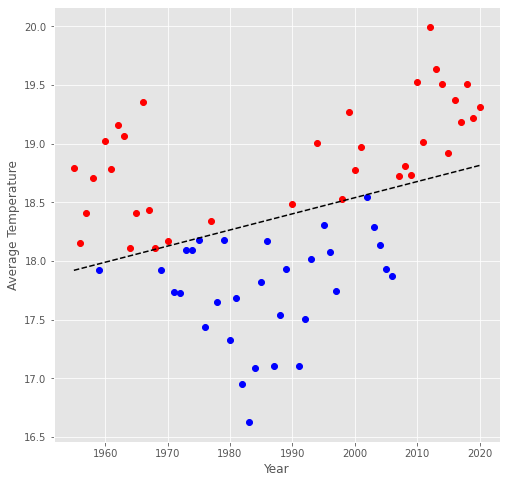

In [30]:
#https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
avg_year_temp_not_null = avg_year_temp[~ avg_year_temp.isnull()] # we use this in case we don't fill avg_temp with the average
                                                                 # of max and min
years = np.array(avg_year_temp_not_null.index)
coef = np.polyfit(years, np.array(avg_year_temp_not_null),1)
poly1d_fn = np.poly1d(coef)
is_year_hot = avg_year_temp_not_null > poly1d_fn(years)

plt.figure(figsize=(8, 8))
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.plot(years[is_year_hot], avg_year_temp_not_null[is_year_hot], "ro")
plt.plot(years[~ is_year_hot], avg_year_temp_not_null[~ is_year_hot], "bo")
plt.plot(years, poly1d_fn(years), '--k')

* We can easily observe that it semms like the temperature is increasing.
* This plot comes in alignment with our interpretation of the first graph we generated.

* Next, we will add to our dataframe a new column that will contain the 30-day rolling average temperature for each day

In [31]:
df["rolling_avg_temp"] = df["avg_temp"].rolling(30, min_periods=1).mean()
df[1000:1005]

date  prcp  avg_temp  year  rolling_avg_temp
1000 1957-09-27   0.0      24.6  1957         24.846667
1001 1957-09-28   0.6      23.1  1957         24.700000
1002 1957-09-29   0.0      22.3  1957         24.516667
1003 1957-09-30   0.0      22.8  1957         24.380000
1004 1957-10-01   0.0      23.3  1957         24.263333

* Also a column that shows the day of the year for every observation will come in handy later.

In [32]:
df["day_of_year"] = df["date"].dt.dayofyear
df.head(5)

date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
0 1955-01-01   0.0     14.35  1955         14.350000            1
1 1955-01-02   2.0     10.70  1955         12.525000            2
2 1955-01-03   0.0     12.70  1955         12.583333            3
3 1955-01-04   0.0     13.05  1955         12.700000            4
4 1955-01-05   0.0     13.15  1955         12.790000            5

* Intending to create a different plot for each year, it is convenient to group our data.

In [33]:
df_grouped_year = df.groupby("year")
for year, year_group in list(df_grouped_year)[:5]:
    print(year)
    print(year_group[:3])

1955
        date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
0 1955-01-01   0.0     14.35  1955         14.350000            1
1 1955-01-02   2.0     10.70  1955         12.525000            2
2 1955-01-03   0.0     12.70  1955         12.583333            3
1956
          date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
365 1956-01-01   0.0     16.35  1956         13.298333            1
366 1956-01-02   0.0     14.50  1956         13.405000            2
367 1956-01-03   0.0     12.15  1956         13.396667            3
1957
          date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
731 1957-01-01   0.0       9.8  1957         10.795000            1
732 1957-01-02   0.0      10.3  1957         10.641667            2
733 1957-01-03   0.3      10.4  1957         10.521667            3
1958
           date  prcp  avg_temp  year  rolling_avg_temp  day_of_year
1096 1958-01-01   0.0      12.1  1958         11.503333            1
1097 1958-01-02   0.0      11.8  1

* We will also use our baseline period, 1974-1999, as a yardstick.

In [34]:
baseline_period = df.loc[df["year"].isin(range(1974, 2000))] # all days from 1974-1999

* To get the average temperature of each yearday during our baseline we will first **pivot** our table.

In [35]:
base_avg_temp = baseline_period.pivot(index="year", columns="day_of_year", values="avg_temp")
base_avg_temp.head(5)

day_of_year   1     2     3     4    5    6     7     8    9     10   ...  \
year                                                                  ...   
1974         11.6  13.7  12.2  10.8  9.6  8.7   9.7   9.7  8.5   9.3  ...   
1975          8.7   7.5   7.8   7.2  7.7  8.9  10.9  12.9  7.6   5.8  ...   
1976         11.3  12.4  13.6  13.6  8.4  9.5  11.4  10.6  8.7   9.1  ...   
1977         10.2   9.1   9.1   7.4  6.2  6.7   6.6   7.3  9.4  10.2  ...   
1978          7.0   4.6   6.1   8.9  9.4  4.2   4.4   5.2  2.3   4.9  ...   

day_of_year   357   358   359   360   361   362   363   364   365   366  
year                                                                     
1974         11.1  11.3  11.1  10.2  11.7  11.6  11.6  12.0  12.8   NaN  
1975          8.3  10.1  12.3   9.5   7.1   8.7   9.6   9.7  10.8   NaN  
1976         10.5   9.1   9.1   9.9  10.3   8.2   5.6   7.0  13.4  12.6  
1977          7.6   7.3   9.7  10.2   7.5   7.9  12.1  15.0  14.2   NaN  
1978         14.1  10.8  11.1  13.0  12.4  14.0  14.1  14.9  14.4   NaN  

[5 rows x 366 columns]

* Now we can calculate the average temperature of each yearday during the baseline period.

In [36]:
base_yearday_avg_temp = base_avg_temp.mean()
base_yearday_avg_temp.head(5)

day_of_year
1    10.365385
2    10.707692
3    10.207692
4     9.634615
5     9.919231
dtype: float64

* And as we mentioned before we will use a 30-day rolling average to smooth the line, that we will draw.

In [37]:
base_yearday_roll_avg_temp = base_yearday_avg_temp.rolling(30, min_periods=1).mean()
base_yearday_roll_avg_temp.head(5)

day_of_year
1    10.365385
2    10.536538
3    10.426923
4    10.228846
5    10.166923
dtype: float64

### Plot
* It is time to generate our plot!
* We will draw a different line for each year, the colors are ranging from light orange to dark orange, the darker the color, the latter the year.
* The black line is the average daily temperature for the baseline period of 1974-1999.

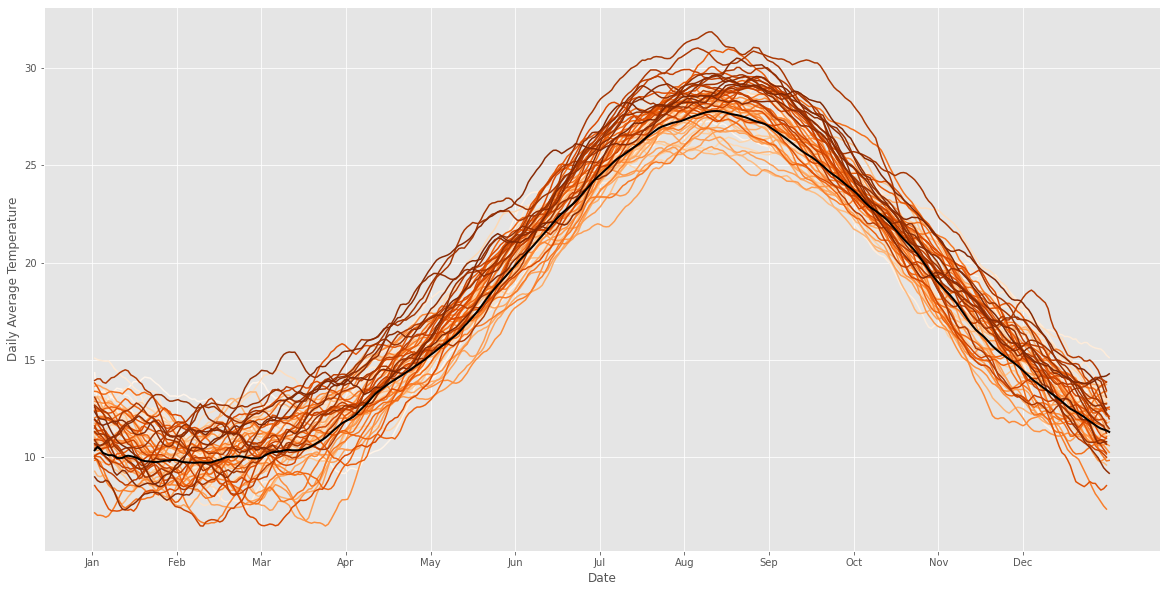

In [38]:
def get_oranges_for_plot(): # returns a dictionary, that contains the appropriate color for every year
    years = list(avg_year_temp_not_null.index) # we use again the avg_year_temp_not_null, we previously created,
                                               # to get the years that contain at least one avg_temp
    cmap = plt.get_cmap('Oranges')
    colors = [cmap(i) for i in np.linspace(0, 1, len(years))] # https://stackoverflow.com/questions/16006572/plotting-different-colors-in-matplotlib
    return dict(zip(years, colors)) # https://stackoverflow.com/questions/209840/how-do-i-convert-two-lists-into-a-dictionary
    
plt.style.use('ggplot')
plt.figure(figsize=(20, 10))
plt.xlabel("Date")
plt.ylabel("Daily Average Temperature")
colors = get_oranges_for_plot()

for year, year_group in list(df_grouped_year):
    # we use this condition in case we don't fill avg_temp with the average of max and min and to plot only 
    # the years that contain at least one avg_temp
    if (year_group["avg_temp"].count() == 0):
        continue      
    plt.plot(year_group["day_of_year"], year_group["rolling_avg_temp"], color=colors[year])

# baseline plot
plt.plot(base_yearday_roll_avg_temp, color="black", linewidth=2)
# for the x axis months values
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
_ = plt.xticks(np.linspace(0,335,12), months) # assignment to _ is used in order to not print the list of matplotlib xticks 
                                              # (https://stackoverflow.com/questions/12056115/disable-the-output-of-matplotlib-pyplot)
                                              # also, here the year period is equally divided per month, but if we wanted more
                                              # accuracy we should use the appropriate space for each month.

### Interpretation
* Generally, darker colors are higher than the lighter ones, which means that the temperature has increased during the observed period.
* This trend isn't detected only a particular season, but through the whole year.
* An important increase of about 2.5 Celsius degrees can be noted the latter years relatively to the baseline.

These points generalize the interpretation we made in the previous sector, as it seems that the tendency of increasing temperature isn't detected only a certain period of the year.

## Extreme Temperature Events
* The number of extreme events is another measure that climatologists use. Extreme events are defined as those beyond 5% or 10% from the expected value.
* For our analysis, we will focus on the extreme heat events, that are 10% above the baseline.
* To do that we will compare every day of every year with the corresponding extreme value of the baseline. Here we can follow two approaches: 
    1. using yeardays (1 to 366)
    2. using months and monthdays (1.1 to 31.12)  
    Is there a difference? The answer is yes because of  leap years.  
    We will seize the opportunity to use multidimensional index and we will follow the second approach.

* We will start by adding two columns to our basic dataframe, one for the month and a second for the month day.

In [39]:
df["month"] = df["date"].dt.month
df["month_day"] = df["date"].dt.day
df.head(5)

date  prcp  avg_temp  year  rolling_avg_temp  day_of_year  month  \
0 1955-01-01   0.0     14.35  1955         14.350000            1      1   
1 1955-01-02   2.0     10.70  1955         12.525000            2      1   
2 1955-01-03   0.0     12.70  1955         12.583333            3      1   
3 1955-01-04   0.0     13.05  1955         12.700000            4      1   
4 1955-01-05   0.0     13.15  1955         12.790000            5      1   

   month_day  
0          1  
1          2  
2          3  
3          4  
4          5

* Then, we will create our new dataframe that will have <code>years</code> as index, <code>month</code> and <code>month_day</code> as columns and <code>avg_temp</code> as values.

In [40]:
month_day_avg_temp = df.pivot(index="year", columns=["month", "month_day"], values="avg_temp")
month_day_avg_temp.head(5)

month         1                                                                \
month_day     1      2      3      4      5      6      7      8     9     10   
year                                                                            
1955       14.35  10.70  12.70  13.05  13.15  14.25  13.30  15.80  14.7  13.2   
1956       16.35  14.50  12.15  11.65   8.60   7.15   9.15  10.35  10.3   8.7   
1957        9.80  10.30  10.40   8.10   8.90   8.55   9.65   8.60   7.4   9.5   
1958       12.10  11.80  12.10  10.30   8.50  10.20  13.60  15.60   7.8   5.8   
1959       10.90  12.45  13.70  15.50  12.55   8.20   7.15   9.40  13.5  12.5   

month      ...     12                                                       \
month_day  ...     23     24    25     26    27     28    29     30     31   
year       ...                                                               
1955       ...  14.85  14.25  12.0  11.60  10.2   8.55   8.9   9.25  13.80   
1956       ...   9.80  14.30  12.4  10.30  11.2   8.30   9.0   9.15   8.15   
1957       ...   8.90   9.90   9.3  10.20  10.2   9.80  11.9  15.70  15.80   
1958       ...  16.80  16.40  15.3  12.90  13.6  12.40  13.5  11.20   9.00   
1959       ...  12.30  11.85  13.0  12.15  11.8  13.55  13.6  10.50  10.35   

month        2   
month_day    29  
year             
1955        NaN  
1956       9.35  
1957        NaN  
1958        NaN  
1959        NaN  

[5 rows x 366 columns]

* We will use the baseline period to define the extreme temperatures for each day-of-month.
* So we have to, first, calculate the average temperature for each day-of-month within the period 1974-1999.

In [41]:
base_month_day_avg_temp = month_day_avg_temp.loc[1974:1999]
baseline_avg_temp = base_month_day_avg_temp.mean()
baseline_avg_temp.head(5)

month  month_day
1      1            10.365385
       2            10.707692
       3            10.207692
       4             9.634615
       5             9.919231
dtype: float64

* So the extreme temperature for each day is: expected value + 10% * |expected value| (absolute value here because of potential negative values).

In [42]:
baseline_extreme_temp = baseline_avg_temp.map(lambda x : x + 0.1 * abs(x))
baseline_extreme_temp.head(5)

month  month_day
1      1            11.401923
       2            11.778462
       3            11.228462
       4            10.598077
       5            10.911154
dtype: float64

* We will find the difference: average temperature - extreme temperature for all days.

In [43]:
diff_avg_extr = month_day_avg_temp - baseline_extreme_temp
diff_avg_extr.head(5)

month            1                                                     \
month_day        1         2         3         4         5         6    
year                                                                    
1955       2.948077 -1.078462  1.471538  2.451923  2.238846  3.440385   
1956       4.948077  2.721538  0.921538  1.051923 -2.311154 -3.659615   
1957      -1.601923 -1.478462 -0.828462 -2.498077 -2.011154 -2.259615   
1958       0.698077  0.021538  0.871538 -0.298077 -2.411154 -0.609615   
1959      -0.501923  0.671538  2.471538  4.901923  1.638846 -2.609615   

month                                              ...        12            \
month_day        7         8         9         10  ...        23        24   
year                                               ...                       
1955       2.139231  4.939615  4.660385  2.508846  ...  2.508846  2.585769   
1956      -2.010769 -0.510385  0.260385 -1.991154  ... -2.541154  2.635769   
1957      -1.510769 -2.260385 -2.639615 -1.191154  ... -3.441154 -1.764231   
1958       2.439231  4.739615 -2.239615 -4.891154  ...  4.458846  4.735769   
1959      -4.010769 -1.460385  3.460385  1.808846  ... -0.041154  0.185769   

month                                                                  \
month_day        25        26        27        28        29        30   
year                                                                    
1955       0.335769  0.612692 -0.546154 -2.678462 -2.954615 -3.239231   
1956       0.735769 -0.687308  0.453846 -2.928462 -2.854615 -3.339231   
1957      -2.364231 -0.787308 -0.546154 -1.428462  0.045385  3.210769   
1958       3.635769  1.912692  2.853846  1.171538  1.645385 -1.289231   
1959       1.335769  1.162692  1.053846  2.321538  1.745385 -1.989231   

month                      2   
month_day        31        29  
year                           
1955       1.691538       NaN  
1956      -3.958462 -0.953333  
1957       3.691538       NaN  
1958      -3.108462       NaN  
1959      -1.758462       NaN  

[5 rows x 366 columns]

* At this moment, we prefer the <code>diff_avg_extr</code> to have <code>month</code> and <code>month_day</code> as rows and <code>year</code> as columns.
* In this way, it is easier to exctract information for each year.
* So, we will transpose the table.

In [44]:
diff_avg_extr_t = diff_avg_extr.transpose()
diff_avg_extr_t.head(5)

year                 1955      1956      1957      1958      1959      1960  \
month month_day                                                               
1     1          2.948077  4.948077 -1.601923  0.698077 -0.501923 -2.501923   
      2         -1.078462  2.721538 -1.478462  0.021538  0.671538 -3.578462   
      3          1.471538  0.921538 -0.828462  0.871538  2.471538 -3.728462   
      4          2.451923  1.051923 -2.498077 -0.298077  4.901923 -0.398077   
      5          2.238846 -2.311154 -2.011154 -2.411154  1.638846 -1.961154   

year                 1961      1962      1963      1964  ...      2011  \
month month_day                                          ...             
1     1          0.598077  1.498077  3.698077 -2.201923  ... -1.501923   
      2          0.421538  1.921538  2.121538 -2.478462  ... -0.278462   
      3          2.371538  5.571538  1.971538 -3.628462  ... -0.228462   
      4          3.201923  1.101923  5.801923 -0.198077  ... -0.798077   
      5          4.388846 -2.111154  4.088846 -2.211154  ... -1.611154   

year                 2012      2013      2014      2015      2016      2017  \
month month_day                                                               
1     1         -1.201923 -0.101923 -1.601923 -7.001923 -7.601923 -5.401923   
      2         -2.278462 -0.878462 -0.478462 -7.278462 -3.878462 -3.378462   
      3         -1.528462  0.371538 -0.128462 -5.728462  0.271538 -0.128462   
      4          0.701923  0.601923  0.201923  0.501923  2.801923  1.201923   
      5          0.188846  0.388846  0.888846 -4.711154  6.288846  2.288846   

year                 2018      2019      2020  
month month_day                                
1     1         -0.101923 -3.101923 -3.001923  
      2          1.921538 -4.378462 -4.678462  
      3          0.271538 -4.828462 -2.328462  
      4         -0.998077 -4.898077 -0.198077  
      5         -0.511154 -7.011154 -1.311154  

[5 rows x 66 columns]

* Now we can calculate the number of days with extreme average temperature for each year.
* An extreme heat event is a day that the difference: average temperature - extreme temperature is positive.

In [45]:
num_extreme_events = (diff_avg_extr_t > 0).sum()
num_extreme_events.head(5)

year
1955    128
1956    113
1957    116
1958    130
1959     96
dtype: int64

* Then, we will calculate the percentage of the extreme heat events over the number of observations for each year.
* We don't have the same number of observation for all years, so it's a better indicator.

In [46]:
pct_extreme_events = num_extreme_events / diff_avg_extr_t.count()
pct_extreme_events.head(5)

year
1955    0.350685
1956    0.308743
1957    0.318681
1958    0.356164
1959    0.263014
dtype: float64

* Again for our plot we will use our baseline period as yardstick.
* For that purpose, we will calculate the average percentage of days with extreme temperature for the baseline period.

In [47]:
baseline_extreme_events_pct = pct_extreme_events[pct_extreme_events.index.isin(range(1974,2000))].mean()
baseline_extreme_events_pct

0.24834654827917796

### Plot
* We can now plot our data!
* We will use the orange color for the years that are above the baseline and blue for the years below it.

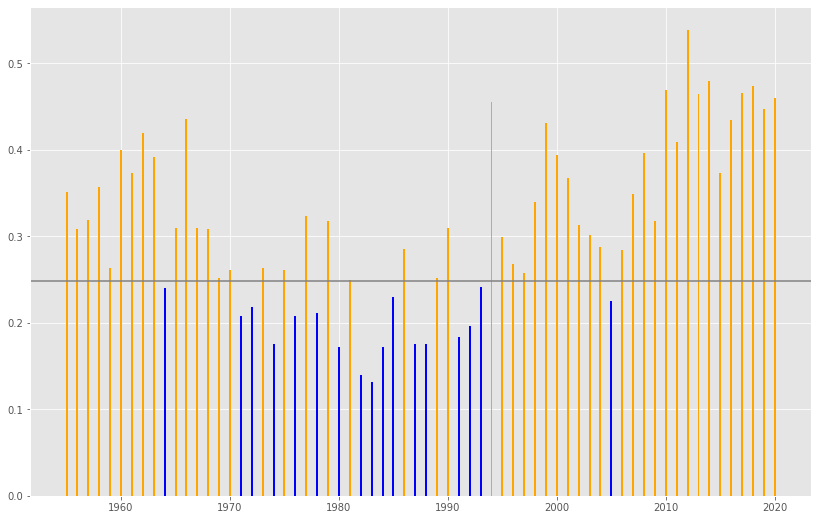

In [48]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 9))

plt.bar(pct_extreme_events.index, 
        pct_extreme_events,
        width=0.180,
        color=np.where(pct_extreme_events < baseline_extreme_events_pct, 'blue', 'orange'))
plt.axhline(baseline_extreme_events_pct, color="gray")

### Normalization
* The procedure that we previously followed has two problems, that are related to the nature of Celsius as units of measurement:
    1. We would get very different results, if we used another unit of measurement like Fahrehneit. That's because the 10% difference is related to the unit of measurement we use, as temperature units are not proportionally connected.
    2. Celsius zero point is different that the absolute zero, which has implications when calculating percentage changes. For example a 10% increase from -10 is 1 Celsius degree, while a 10% increase from 5 is 0.5 Celsius degree, which means lower percentage change for higher temperature.
* A first way to solve this issue is to use Kelvin degrees. This would work fine, we just had to adjust the 10% difference as to what we consider an extreme event.
* Another solution would be to normalize our data. That's what we will do here.
* We will use the formula x' = (x - xmin)/(xmax - xmin)
* In other respects, the procedure that we will follow is the same as before, so the only complemenatry text to our code will be a note: ***Normalization***, before every component that we will normalize our data.

Note: ***Normalization***

In [49]:
min_avg_temp = df["avg_temp"].min()
max_avg_temp = df["avg_temp"].max()
month_day_avg_temp_norm = (df.pivot(index="year", columns=["month", "month_day"], values="avg_temp")- min_avg_temp)/ \
                            (max_avg_temp - min_avg_temp)
month_day_avg_temp_norm.head(5)

month            1                                                     \
month_day        1         2         3         4         5         6    
year                                                                    
1955       0.443089  0.344173  0.398374  0.407859  0.410569  0.440379   
1956       0.497290  0.447154  0.383469  0.369919  0.287263  0.247967   
1957       0.319783  0.333333  0.336043  0.273713  0.295393  0.285908   
1958       0.382114  0.373984  0.382114  0.333333  0.284553  0.330623   
1959       0.349593  0.391599  0.425474  0.474255  0.394309  0.276423   

month                                              ...        12            \
month_day        7         8         9         10  ...        23        24   
year                                               ...                       
1955       0.414634  0.482385  0.452575  0.411924  ...  0.456640  0.440379   
1956       0.302168  0.334688  0.333333  0.289973  ...  0.319783  0.441734   
1957       0.315718  0.287263  0.254743  0.311653  ...  0.295393  0.322493   
1958       0.422764  0.476965  0.265583  0.211382  ...  0.509485  0.498645   
1959       0.247967  0.308943  0.420054  0.392954  ...  0.387534  0.375339   

month                                                                  \
month_day        25        26        27        28        29        30   
year                                                                    
1955       0.379404  0.368564  0.330623  0.285908  0.295393  0.304878   
1956       0.390244  0.333333  0.357724  0.279133  0.298103  0.302168   
1957       0.306233  0.330623  0.330623  0.319783  0.376694  0.479675   
1958       0.468835  0.403794  0.422764  0.390244  0.420054  0.357724   
1959       0.406504  0.383469  0.373984  0.421409  0.422764  0.338753   

month                      2   
month_day        31        29  
year                           
1955       0.428184       NaN  
1956       0.275068  0.307588  
1957       0.482385       NaN  
1958       0.298103       NaN  
1959       0.334688       NaN  

[5 rows x 366 columns]

Note: ***Normalization***

In [50]:
# base_month_day_avg_temp = month_day_avg_temp.loc[1974:1999] # already calculated
baseline_avg_temp_norm = (base_month_day_avg_temp.mean() - min_avg_temp)/ (max_avg_temp - min_avg_temp)
baseline_avg_temp_norm.head(5)

month  month_day
1      1            0.335105
       2            0.344382
       3            0.330832
       4            0.315301
       5            0.323014
dtype: float64

In [51]:
baseline_extreme_temp_norm = baseline_avg_temp_norm.map(lambda x : x + 0.1 * abs(x))
baseline_extreme_temp_norm.head(5)

month  month_day
1      1            0.368616
       2            0.378820
       3            0.363915
       4            0.346831
       5            0.355316
dtype: float64

In [52]:
diff_avg_extr_norm = month_day_avg_temp_norm - baseline_extreme_temp_norm
diff_avg_extr_norm.head(5)

month            1                                                     \
month_day        1         2         3         4         5         6    
year                                                                    
1955       0.074474 -0.034647  0.034459  0.061028  0.055253  0.087815   
1956       0.128674  0.068334  0.019554  0.023087 -0.068053 -0.104597   
1957      -0.048833 -0.045487 -0.027872 -0.073119 -0.059923 -0.066656   
1958       0.013498 -0.004836  0.018199 -0.013498 -0.070763 -0.021941   
1959      -0.019022  0.012779  0.061559  0.127423  0.038993 -0.076141   

month                                              ...        12            \
month_day        7         8         9         10  ...        23        24   
year                                               ...                       
1955       0.052554  0.128445  0.120878  0.062570  ...  0.062570  0.064655   
1956      -0.059912 -0.019252  0.001636 -0.059381  ... -0.074286  0.066010   
1957      -0.046362 -0.066677 -0.076954 -0.037701  ... -0.098676 -0.053231   
1958       0.060684  0.123025 -0.066114 -0.137972  ...  0.115416  0.122921   
1959      -0.114113 -0.044997  0.088357  0.043600  ... -0.006535 -0.000386   

month                                                                  \
month_day        25        26        27        28        29        30   
year                                                                    
1955       0.003679  0.011184 -0.020221 -0.078007 -0.085491 -0.093204   
1956       0.014519 -0.024046  0.006879 -0.084782 -0.082781 -0.095914   
1957      -0.069491 -0.026756 -0.020221 -0.044132 -0.004190  0.081593   
1958       0.093110  0.046414  0.071920  0.026329  0.039170 -0.040359   
1959       0.030780  0.026089  0.023139  0.057494  0.041880 -0.059329   

month                      2   
month_day        31        29  
year                           
1955       0.040421       NaN  
1956      -0.112695 -0.031256  
1957       0.094622       NaN  
1958      -0.089660       NaN  
1959      -0.053075       NaN  

[5 rows x 366 columns]

In [53]:
diff_avg_extr_norm_t = diff_avg_extr_norm.transpose()
diff_avg_extr_norm_t.head(5)

year                 1955      1956      1957      1958      1959      1960  \
month month_day                                                               
1     1          0.074474  0.128674 -0.048833  0.013498 -0.019022 -0.073223   
      2         -0.034647  0.068334 -0.045487 -0.004836  0.012779 -0.102397   
      3          0.034459  0.019554 -0.027872  0.018199  0.061559 -0.106462   
      4          0.061028  0.023087 -0.073119 -0.013498  0.127423 -0.016208   
      5          0.055253 -0.068053 -0.059923 -0.070763  0.038993 -0.058568   

year                 1961      1962      1963      1964  ...      2011  \
month month_day                                          ...             
1     1          0.010788  0.035178  0.094799 -0.065093  ... -0.046123   
      2          0.006004  0.046654  0.052074 -0.072587  ... -0.012966   
      3          0.058849  0.145570  0.048009 -0.103752  ... -0.011611   
      4          0.081353  0.024442  0.151814 -0.010788  ... -0.027048   
      5          0.113519 -0.062633  0.105389 -0.065343  ... -0.049083   

year                 2012      2013      2014      2015      2016      2017  \
month month_day                                                               
1     1         -0.037992 -0.008182 -0.048833 -0.195174 -0.211434 -0.151814   
      2         -0.067167 -0.029227 -0.018386 -0.202668 -0.110527 -0.096977   
      3         -0.046842  0.004649 -0.008901 -0.160663  0.001939 -0.008901   
      4          0.013602  0.010892  0.000052  0.008182  0.070513  0.027152   
      5         -0.000302  0.005118  0.018668 -0.133094  0.165009  0.056608   

year                 2018      2019      2020  
month month_day                                
1     1         -0.008182 -0.089483 -0.086773  
      2          0.046654 -0.124078 -0.132208  
      3          0.001939 -0.136273 -0.068522  
      4         -0.032468 -0.138159 -0.010788  
      5         -0.019272 -0.195424 -0.040953  

[5 rows x 66 columns]

In [54]:
num_extreme_events_norm = (diff_avg_extr_norm_t > 0).sum()
num_extreme_events_norm.head(5)

year
1955    123
1956    103
1957    100
1958    118
1959     81
dtype: int64

In [55]:
pct_extreme_events_norm = num_extreme_events_norm / diff_avg_extr_norm_t.count()
pct_extreme_events.head(5)

year
1955    0.350685
1956    0.308743
1957    0.318681
1958    0.356164
1959    0.263014
dtype: float64

In [56]:
baseline_extreme_events_pct_norm = pct_extreme_events_norm[pct_extreme_events_norm.index.isin(range(1974,2000))].mean()
baseline_extreme_events_pct_norm

0.223177402730513

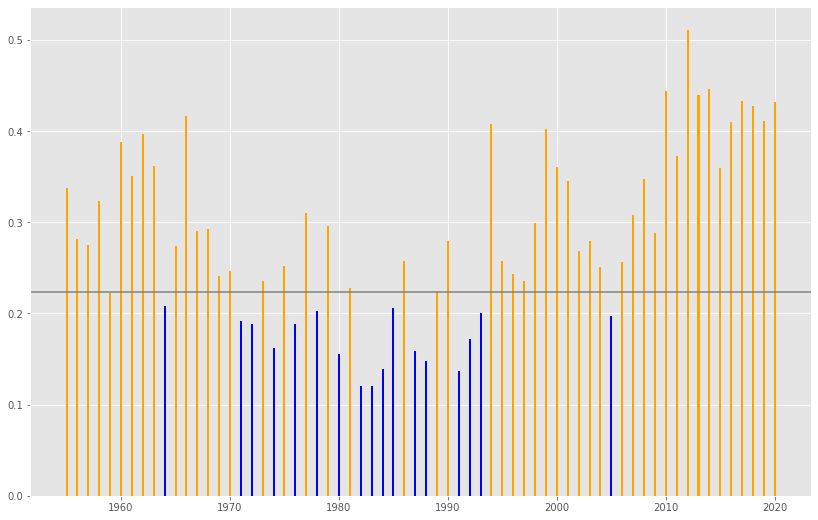

In [57]:
plt.style.use('ggplot')
plt.figure(figsize=(14, 9))

plt.bar(pct_extreme_events_norm.index, 
        pct_extreme_events_norm,
        width=0.184,
        color=np.where(pct_extreme_events < baseline_extreme_events_pct, 'blue', 'orange'))
plt.axhline(baseline_extreme_events_pct_norm, color="gray")

### Interpretation
* Extreme events between 1973-1993 are relativley low.
* The percentage of extreme events per year after 1993 is significantly larger, than the period before.

It looks like the climate change is connected with extreme weather, or, at least, increase in extreme heat events. That is a serious problem, as it does not only cause problems in human living, but also disturbs the smooth operation of different ecosystems.

## Precipitation
* We will also study the precipitation in the period 1955-2020.
* More specifically, we will focus on the ratio of rainfall over rainy days over the years.

* Again we will use <code>pivot</code>, but this time for the precipitation.
* We want <code>day_of_year</code> as index and <code>year</code> as columns.

In [58]:
full_years_prcp = df.pivot(index="day_of_year", columns="year", values="prcp")
full_years_prcp.head(5)

year         1955  1956  1957  1958  1959  1960  1961  1962  1963  1964  ...  \
day_of_year                                                              ...   
1             0.0   0.0   0.0   0.0   0.0   1.1   0.0   0.0   0.0   0.1  ...   
2             2.0   0.0   0.0   0.0   5.7   0.0   0.0   0.0   0.0   0.0  ...   
3             0.0   0.0   0.3   0.0   5.7   5.6   0.0   0.0   0.0   0.0  ...   
4             0.0   0.0   4.0   0.0   0.0  23.8   0.0   0.0   0.0  13.4  ...   
5             0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0  ...   

year         2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  
day_of_year                                                              
1             0.0   0.0   0.0   8.4   1.4   0.0   0.0   0.0  68.3   0.0  
2             0.0   0.0   0.0   0.2   0.0   0.5   0.0   0.0   0.0   1.5  
3            18.8   0.0   0.2   0.0   0.0   2.2   0.0   1.0   0.5   3.3  
4             6.1   0.0   0.0   0.0   0.0   0.0   0.0   0.3  10.4   0.0  
5             0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   4.8   0.0  

[5 rows x 66 columns]

* It is also necessary to calculate the number of rainy days for each year
* A rainy day is a day that its precipitation is larger than zero.

In [59]:
num_rainy_days = (full_years_prcp > 0).sum()
num_rainy_days.head(5)

year
1955    68
1956    52
1957    73
1958    68
1959    62
dtype: int64

* We must also calculate the total precipitation for every year.

In [60]:
total_prcp = full_years_prcp.sum()
total_prcp.head(5)

year
1955    547.0
1956    281.3
1957    303.2
1958    350.0
1959    214.0
dtype: float64

* And now we can find the average precipitation per year.

In [61]:
avg_prcp = total_prcp / num_rainy_days
avg_prcp.tail(10)

year
2011    7.484211
2012    6.387500
2013    7.777273
2014    6.856250
2015    7.185366
2016    6.228571
2017    6.339583
2018    6.912727
2019    9.827586
2020    5.536842
dtype: float64

* We will also plot a line of the 10 years rolling average.

In [62]:
roll_avg_prcp = avg_prcp.rolling(10, min_periods=1).mean()
roll_avg_prcp.head(5)

year
1955    8.044118
1956    6.726867
1957    5.869053
1958    5.688554
1959    5.241166
dtype: float64

### Plot
* We have now calcuated everything we need for our plot!

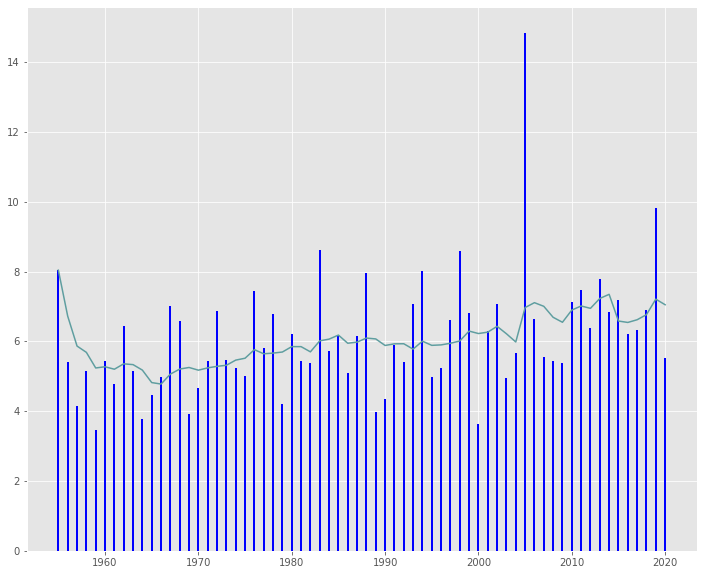

In [63]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 10))

plt.bar(avg_prcp.index, 
        avg_prcp,
        width=0.21,
        color='blue')
plt.plot(roll_avg_prcp, color="cadetblue")

### Interpretation
* As the 10 year rolling average shows, the average precipitation slowly increases as the years pass.
* Especially, the last 10 years the average precipitation is almost exclusively above 6 mm, while the previous years this was far more rare.

As we concluded before the weather seems to become more extreme, as a rusult of the climate change. Here we can see that we are getting rain in more concentrated bursts, as the average precipitation (per rainy day) slowly but steadily increases.